In [1]:
import numpy as np
from math import ceil, floor, sqrt, gamma
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import signal, stats
from scipy.stats import rayleigh

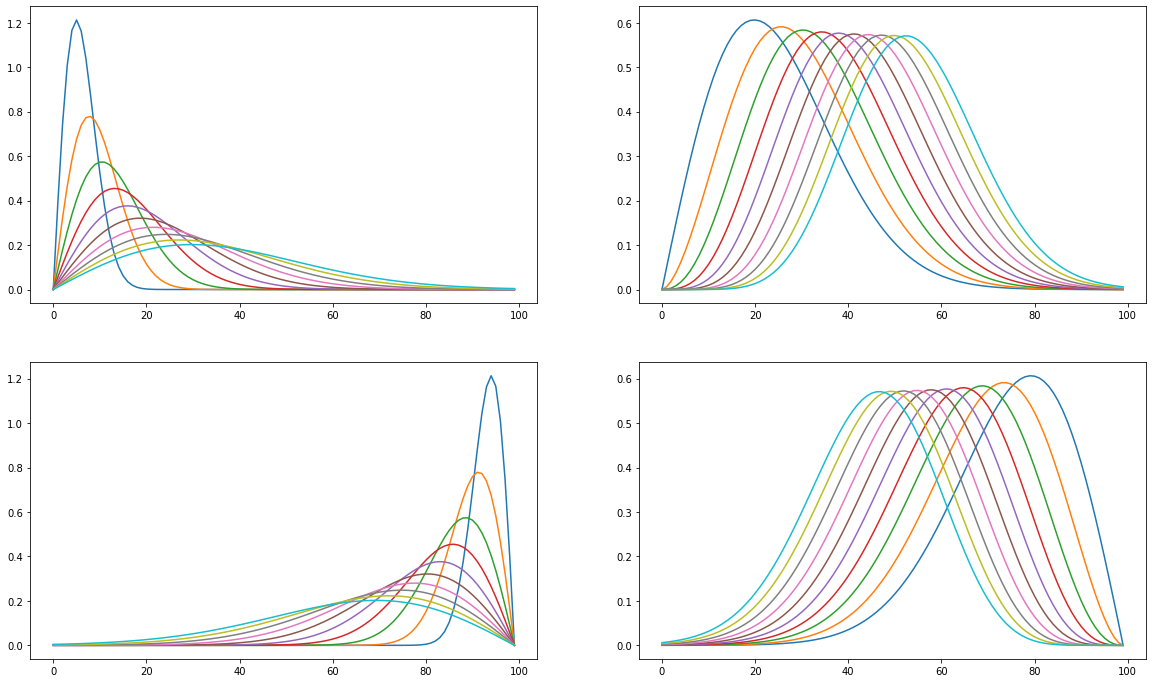

In [2]:
def rayleigh_distribution(size, phi, flipped=False):
    '''Rayleigh distribution
    params:
        size: number of samples in the distribution
        phi: scale parameter of the distribution (0.5 <= phi <= 3)
        flipped: filp the distribution
    return:
        distribution
    '''
    x = np.linspace(0,10,size)
    rv = (x/(phi**2))*np.exp((-x**2)/(2*(phi**2)))
    if flipped:
        rv = np.flip(rv)
    return rv
def chi_distribution(size, k, flipped=False):
    '''Chi distribution
    params:
        size: number of samples in the distribution
        k: scale parameter of the distribution (2 <= k <= 8)
        flipped: filp the distribution
    return:
        distribution
    '''
    x = np.linspace(0,5,size)
    rv = ((x**(k-1))*np.exp(-(x**2)/2))/((2**(-1+k/2))*gamma(k/2))
    if flipped:
        rv = np.flip(rv)
    return rv


plt.figure(figsize=(20,12))
nbr_distribution = 10
size = 100
plt.subplot(2,2,1)
for phi in np.linspace(0.5,3,nbr_distribution):
    plt.plot(rayleigh_distribution(size, phi))
plt.subplot(2,2,2)
for k in np.linspace(2,8,nbr_distribution):
    plt.plot(chi_distribution(size, k))
plt.subplot(2,2,3)
for phi in np.linspace(0.5,3,nbr_distribution):
    plt.plot(rayleigh_distribution(size, phi, flipped=True))
plt.subplot(2,2,4)
for k in np.linspace(2,8,nbr_distribution):
    plt.plot(chi_distribution(size, k, flipped=True))
plt.show()

In [ ]:
def background_noise(size):
    '''2D scaled gaussian noise
    params:
        size: size of the gaussian noise per axis
    return:
        2D gaussian noise
    '''
    mean, cov = [5,5], [[1, 0], [0, 1]]  # diagonal covariance
    noise = np.random.multivariate_normal(mean, cov, (size,size)).T
    noise = (noise[1]-noise[1].min())/(noise[1].max()-noise[1].min())
    return noise

def whistler(A, B, size):
    '''Generate a whistler in 1D
    params:
        A: amplitude of whistler [can be ignored]
        B: decay of the whistlers
        size: number of sample of the whistler
    return:
        Whistler y values
    '''
    L_min, L_max = 1, 10
    L = np.linspace(L_min, L_max, size)
    return np.array(10**(A)*(10**L)**(B))

def whistlers(B, b, param, size):
    '''Generate a set of whistlers in 2D with added amplitude distribution
    params:
        B: decay of the whistlers
        b: variation in the decay of the whistlers
        size: number of sample of the whistler
    return:
        A 2D set of whitlers in a noisy background
    '''
    decays = np.linspace(B-b, B+b, size)
    noise = background_noise(size)*5
    data = np.zeros(noise.shape)
    y_max = np.array([whistler(0,decay,size).max() for decay in decays]).max()
        
    for decay in decays:
        ampl = whistler(0, decay, size=size)
        x,y,z = np.array(list(range(size))), (ampl/y_max)*(size-1), rayleigh_distribution(size, param) #'''np.full(size,1)'''
        for i,j,k in zip(x,y,range(len(z))):
            data[i,floor(j)] += z[k]
    return data.T, (data+noise).T

plt.figure(figsize=(18,2))
size = 100
decay = -0.5
delta = 0.05 
param = 1.3
plt.subplot(1,3,1)
plt.plot(np.linspace(1, 10, size),whistler(0,decay,size))
plt.subplot(1,3,2)
plt.plot(rayleigh_distribution(size, param))
plt.subplot(1,3,3)
# plt.figure(figsize=(4,4))
data, noisy_data  = whistlers(decay,delta,param,size)
plt.pcolormesh(noisy_data, cmap='jet')
plt.show()

In [ ]:
neq = 1
L = 1.4


<Figure size 432x288 with 0 Axes>

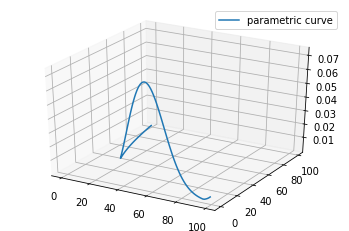

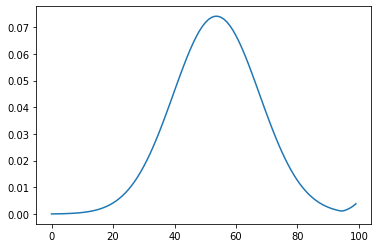

0.0 2.7818258386032086


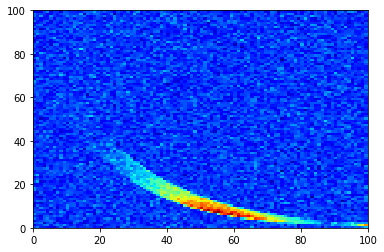

In [107]:
def shifted_gaussian(size, std, shift):
    gaussian = signal.gaussian(size,std)
#     gaussian = signal.general_gaussian(size,p=1.25,sig=std)
#     gaussian = signal.flattop(size)
#     gaussian = signal.windows.general_hamming(size,0.75)
    gaussian = np.roll(gaussian, shift, axis=None)
    tau2 = -(size-1) / np.log(0.01)
    window2 = signal.exponential(size, size-shift, tau2, False)
    return window2*gaussian

def scaled_2d_gaussian(size):
    mean, cov = [0,0], [[1, 0], [0, 1]]  # diagonal covariance
    w = np.random.multivariate_normal(mean, cov, (size,size)).T
    w = (w[1]-w[1].min())/(w[1].max()-w[1].min())
    return w

def whistler(A, B, size=257):
    L_min, L_max = 1.4, 8
    L = np.linspace(L_min, L_max, size)
    return L, np.array(10**(A)*(10**L)**(B))

def whistlers(A,B,b,size=257):
    A = 0
    B = np.linspace(B,B+b,100)
    W = scaled_2d_gaussian(size)
#     W = np.full((size,size),0)
    
    std = int(size/7)
    shift = -int(size/19)
    
    fig = plt.figure()
    axis, ampl = whistler(A,-0.4, size=size)
    x,y,z = np.array(list(range(size))), (ampl/ampl.max())*(size-1),shifted_gaussian(size, std, shift)
    ax = fig.gca(projection='3d')
    ax.plot(x, y, z, label='parametric curve')
    ax.legend()
    plt.figure()
    plt.plot(shifted_gaussian(size, std, shift))
    plt.show()

    y_max = 0
    for i in B:
        axis, ampl = whistler(A,i, size=size)
        y_max = max(y_max, ampl.max())
        
    for i in B:
        axis, ampl = whistler(A,i, size=size)
        x,y,z = np.array(list(range(size))), (ampl/y_max)*(size-1),shifted_gaussian(size, std, shift)+shifted_gaussian(size, std, shift*3)
        ix = 0
        for i,j in zip(x,y):
            W[i,math.floor(j)] += z[ix]
            ix += 1
    return W
    

plt.figure()
Z = whistlers(0,-0.3,0.05,100)
print(Z.min(), Z.max())
plt.pcolormesh(Z.T, cmap='jet')
plt.show()

In [ ]:
# plt.figure()
# B = [-0.5, -0.51, -0.52, -0.53, -0.54, -0.55, -0.56]
# B = np.linspace(-0.2,-0.2+0.09,50)
# size = 50
# for i in B:
#     axis, ampl = whistler(0,i, size=size)
#     x, y, z= np.array(list(range(size))), (ampl/ampl.max())*(size-1),np.full(size,1)
#     plt.scatter(x, y,z)

# size = 50
# plt.figure()
# plt.plot(shifted_gaussian(size, int(size/10), -int(size/5)))

# fig = plt.figure()
# axis, ampl = whistler(0,-0.4, size=size)
# x,y,z = np.array(list(range(size))), (ampl/ampl.max())*(height-1),shifted_gaussian(size, int(size/10), -int(size/5))
# ax = fig.gca(projection='3d')
# ax.plot(x, y, z, label='parametric curve')
# ax.legend()
# # plt.show()


### Whistler spectrorgam

[0 1 2 3 4] [99.         91.68575408 84.91189396 78.63849524 72.82858319]


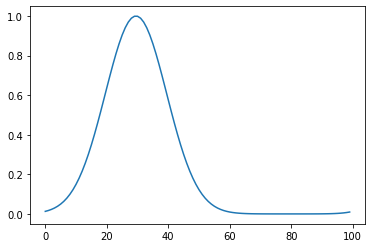

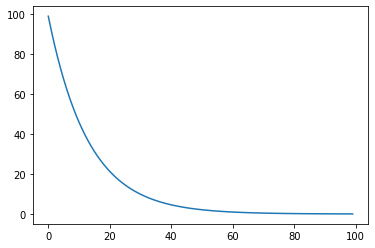

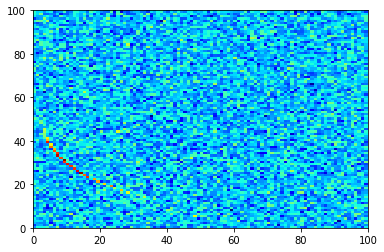

In [100]:
width = 100
height = width

gaussian = signal.gaussian(width,int(width/10))
shifted_gaussian = np.roll(gaussian, -int(2*width/10), axis=None)

axis, ampl = whistler_simulation(0,-0.5, data_point=width)
x,y,z = np.array(list(range(width))), (ampl/ampl.max())*(height-1),shifted_gaussian# np.full(width,1)#shifted_gaussian

plt.figure()
plt.plot(x,shifted_gaussian)

plt.figure()
plt.plot(x,y)

# fig = plt.figure()
# ax = fig.gca(projection='3d')
# ax.plot(x, y, z, label='parametric curve')
# ax.legend()
# plt.show()

print(x[:5], y[:5])

mean = [0,0]
cov = [[1, 0], [0, 1]]  # diagonal covariance
w = np.random.multivariate_normal(mean, cov, (width,height)).T
w = (w[1]-w[1].min())/(w[1].max()-w[1].min())
ix = 0
for i,j in zip(x,y):
    w[i,math.floor(j)] += z[ix]
    ix += 1
plt.figure()
plt.pcolormesh(w,cmap='jet')
plt.show()

(257, 257) 1.0 0.0


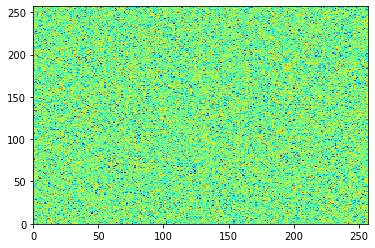

In [76]:
from sklearn.preprocessing import MinMaxScaler
mean = [0,0]
cov = [[1, 0], [0, 1]]  # diagonal covariance
z = np.random.multivariate_normal(mean, cov, (width,height)).T
z = (z[1]-z[1].min())/(z[1].max()-z[1].min())
# z = MinMaxScaler().fit_transform(z[1])
print(z.shape, z.max(), z.min())
plt.pcolormesh(z,cmap='jet')
# plt.axis('equal')
plt.show()